In [1]:
import pandas as pd
import custom_funcs as cf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('poster')
from sklearn.metrics import mean_squared_error as mse
from model_select import find_best_params, params, shortnames
from isoelectric_point import isoelectric_points
from molecular_weight import molecular_weights
from sklearn.cross_validation import train_test_split, ShuffleSplit
from collections import defaultdict

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Purpose

In this notebook, I intend to setup an automated ensemble learning model selection procedure for any given drug.

In [11]:
# Best models
drugs = dict()
drugs['protease'] = ['FPV', 'ATV', 'IDV', 'LPV', 'NFV', 'SQV', 'TPV', 'DRV',]
drugs['nrt'] = ['3TC', 'ABC', 'AZT', 'D4T', 'DDI', 'TDF',]
drugs['nnrt'] = ['EFV', 'NVP', 'ETR', 'RPV',]


best_models = dict()


In [13]:
## GREAT! I THINK WE HAVE THE MASTER FUNCTION FOR READING DATA COMPOSED!
drug = 'ATV'
protein = 'protease'
data, feat_cols = cf.get_cleaned_data(protein, drug) 

# Just checking:
cf.test_data_integrity(data)

## Now, let's do data transformations.
data = cf.to_numeric_rep(data, feat_cols, rep='mw')

# Finally, split the data into a training set, and test set.
X, Y, X_train, X_test, Y_train, Y_test = cf.to_train_test_split(data, feat_cols, drug, test_size=0.1)
sscv = ShuffleSplit(n=len(X_train), n_iter=3, test_size=0.2)

In [3]:
mdl = 'gbr'
gridsearch = find_best_params(mdl=mdl, cv=sscv, scoring='mean_squared_error', X=X_train, Y=Y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV] learning_rate=0.02, n_estimators=100 ............................
[CV] learning_rate=0.02, n_estimators=100 ............................
[CV] learning_rate=0.02, n_estimators=200 ............................
[CV] learning_rate=0.02, n_estimators=100 ............................
[CV] .. learning_rate=0.02, n_estimators=100, score=-0.208107 -   0.2s
[CV] learning_rate=0.02, n_estimators=200 ............................
[CV] .. learning_rate=0.02, n_estimators=100, score=-0.251045 -   0.2s
[CV] learning_rate=0.02, n_estimators=200 ............................
[CV] .. learning_rate=0.02, n_estimators=100, score=-0.161703 -   0.2s
[CV] learning_rate=0.02, n_estimators=300 ............................
[CV] .. learning_rate=0.02, n_estimators=200, score=-0.122133 -   0.3s
[CV] learning_rate=0.02, n_estimators=300 ............................
[CV] .. learning_rate=0.02, n_estimators=200, score=-0.164367 -   0.3s
[CV] learning_r

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.8s


[CV] ... learning_rate=0.1, n_estimators=200, score=-0.130102 -   0.2s
[CV] learning_rate=0.1, n_estimators=200 .............................
[CV] ... learning_rate=0.1, n_estimators=200, score=-0.151250 -   0.2s
[CV] learning_rate=0.1, n_estimators=300 .............................
[CV] ... learning_rate=0.1, n_estimators=200, score=-0.151258 -   0.2s
[CV] learning_rate=0.1, n_estimators=300 .............................
[CV] .. learning_rate=0.06, n_estimators=700, score=-0.141767 -   0.7s
[CV] learning_rate=0.1, n_estimators=400 .............................
[CV] ... learning_rate=0.1, n_estimators=300, score=-0.160314 -   0.3s
[CV] learning_rate=0.1, n_estimators=300 .............................
[CV] ... learning_rate=0.1, n_estimators=300, score=-0.124612 -   0.3s
[CV] learning_rate=0.1, n_estimators=400 .............................
[CV] .. learning_rate=0.06, n_estimators=700, score=-0.160602 -   0.6s
[CV] ... learning_rate=0.1, n_estimators=400, score=-0.102830 -   0.4s
[CV] l

[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   11.2s finished


In [4]:
-gridsearch.best_score_

0.10778190902284536

In [5]:
gridsearch.grid_scores_[0][0]

{'learning_rate': 0.02, 'n_estimators': 100}

In [6]:
# Plot the error as a function of:
# - learning_rate
# - max_depth
# - n_estimators
marginal_scores = dict()
for k in params[mdl].keys():
    marginal_scores[k] = defaultdict(list)

    
for result in gridsearch.grid_scores_:
    for k, v in result[0].items():
        for score in result[2]:
            marginal_scores[k]['scores'].append(score)
            marginal_scores[k]['values'].append(v)

In [7]:
marginal_scores.keys()

dict_keys(['learning_rate', 'n_estimators'])

learning_rate
n_estimators


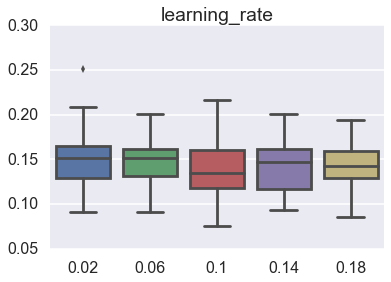

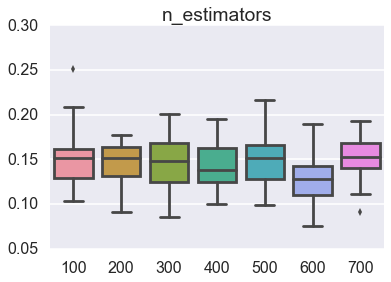

In [8]:
for i, key in enumerate(marginal_scores.keys()):
    print(key)
    fig = plt.figure(i)
    sns.boxplot(x=marginal_scores[key]['values'], y=-np.array(marginal_scores[key]['scores']))
    plt.title(key)

In [9]:
gridsearch.best_estimator_

GradientBoostingRegressor(alpha=0.9, init=None,
             learning_rate=0.13999999999999999, loss='ls', max_depth=3,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

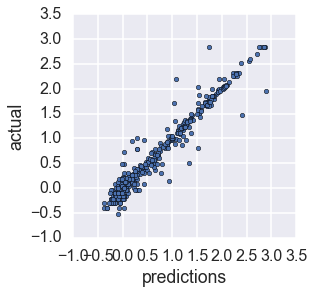

In [10]:
preds = gridsearch.best_estimator_.predict(X)
df = pd.DataFrame([preds, Y]).T
df.columns = ['predictions', 'actual']
df.plot(x='predictions', y='actual', kind='scatter', figsize=(4,4))